# Description

Can we forecast using the Pythagorean Expectation?

1. Divide a season into 2 halves
2. Take Pyth-Expec from 1st half, and see how well it fits with the win percentage in the 2nd half.
3. Control: how well does the wpc for the 1st half fit for the 2nd half?

In [3]:
# %load ./imports.py
# %load /Users/bartev/dev/github-bv/sporty/notebooks/imports.py

## Where am I
!echo $VIRTUAL_ENV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# magics
%load_ext blackcellmagic
# start cell with `%%black` to format using `black`

%load_ext autoreload
# start cell with `%autoreload` to reload module
# https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html

# reload all modules when running
%autoreload 2

# imports

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

from importlib import reload
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# https://plotnine.readthedocs.io/en/stable/

import plotnine as p9
from plotnine import ggplot, aes, facet_wrap

from src.utils import lower_case_col_names


/Users/bartev/.venvs/sport


# Read data

In [4]:
data_dir = Path('../data/raw/wk1-baseball/')
with open(data_dir / 'retrosheet-gamelog-header.txt', 'r') as f:
    retro_cols = f.read().split(',')
MLB = pd.read_csv(data_dir / 'GL2018.csv', names=retro_cols)

In [6]:
print(MLB.shape)
MLB.head()

(2431, 161)


,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,HomeRunsScore,LengthInOuts,DayNight,CompletionInfo,ForfeitInfo,ProtestInfo,ParkID,Attendence,Duration,VisitorLineScore,HomeLineScore,VisitorAB,VisitorH,VisitorD,VisitorT,VisitorHR,VisitorRBI,VisitorSH,VisitorSF,VisitorHBP,VisitorBB,VisitorIBB,VisitorK,VisitorSB,VisitorCS,VisitorGDP,VisitorCI,VisitorLOB,VisitorPitchers,VisitorER,VisitorTER,VisitorWP,VisitorBalks,VisitorPO,VisitorA,VisitorE,VisitorPassed,VisitorDB,VisitorTP,HomeAB,HomeH,HomeD,HomeT,HomeHR,HomeRBI,HomeSH,HomeSF,HomeHBP,HomeBB,HomeIBB,HomeK,HomeSB,HomeCS,HomeGDP,HomeCI,HomeLOB,HomePitchers,HomeER,HomeTER,HomeWP,HomeBalks,HomePO,HomeA,HomeE,HomePassed,HomeDB,HomeTP,UmpireHID,UmpireHName,Umpire1BID,Umpire1BName,Umpire2BID,Umpire2BName,Umpire3BID,Umpire3BName,UmpireLFID,UmpireLFName,UmpireRFID,UmpireRFName,VisitorManagerID,VisitorManagerName,HomeManagerID,HomeManagerName,WinningPitcherID,WinningPitcherName,LosingPitcherID,LosingPitcherNAme,SavingPitcherID,SavingPitcherName,GameWinningRBIID,GameWinningRBIName,VisitorStartingPitcherID,VisitorStartingPitcherName,HomeStartingPitcherID,HomeStartingPitcherName,VisitorBatting1PlayerID,VisitorBatting1Name,VisitorBatting1Position,VisitorBatting2PlayerID,VisitorBatting2Name,VisitorBatting2Position,VisitorBatting3PlayerID,VisitorBatting3Name,VisitorBatting3Position,VisitorBatting4PlayerID,VisitorBatting4Name,VisitorBatting4Position,VisitorBatting5PlayerID,VisitorBatting5Name,VisitorBatting5Position,VisitorBatting6PlayerID,VisitorBatting6Name,VisitorBatting6Position,VisitorBatting7PlayerID,VisitorBatting7Name,VisitorBatting7Position,VisitorBatting8PlayerID,VisitorBatting8Name,VisitorBatting8Position,VisitorBatting9PlayerID,VisitorBatting9Name,VisitorBatting9Position,HomeBatting1PlayerID,HomeBatting1Name,HomeBatting1Position,HomeBatting2PlayerID,HomeBatting2Name,HomeBatting2Position,HomeBatting3PlayerID,HomeBatting3Name,HomeBatting3Position,HomeBatting4PlayerID,HomeBatting4Name,HomeBatting4Position,HomeBatting5PlayerID,HomeBatting5Name,HomeBatting5Position,HomeBatting6PlayerID,HomeBatting6Name,HomeBatting6Position,HomeBatting7PlayerID,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo\n
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,8,51,N,NaN,NaN,NaN,PHO01,48703,216,100001000,30000320x,33,9,0,0,2,2,1,0,0,2,0,12,0,0,2,0,7,5,8,8,0,0,24,8,0,0,0,0,36,12,2,1,0,8,0,0,0,6,0,11,2,0,0,0,10,6,2,2,1,0,27,10,0,0,2,0,cedeg901,Gary Cederstrom,coope901,Eric Cooper,blasc901,Cory Blaser,sches901,Stu Scheurwater,NaN,(none),NaN,(none),blacb001,Buddy Black,lovut001,Tony Lovullo,corbp001,Patrick Corbin,grayj003,Jon Gray,NaN,(none),lambj001,Jake Lamb,grayj003,Jon Gray,corbp001,Patrick Corbin,blacc001,Charlie Blackmon,8,lemad001,DJ LeMahieu,4,arenn001,Nolan Arenado,5,stort001,Trevor Story,6,gonzc001,Carlos Gonzalez,9,desmi001,Ian Desmond,3,parrg001,Gerardo Parra,7,iannc001,Chris Iannetta,2,grayj003,Jon Gray,1,perad001,David Peralta,7,polla001,A.J. Pollock,8,goldp001,Paul Goldschmidt,3,lambj001,Jake Lamb,5,martk001,Ketel Marte,4,avila001,Alex Avila,2,ahmen001,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,8,53,D,NaN,NaN,NaN,ATL03,40208,208,100004000,000002033,31,6,2,0,1,5,0,0,1,6,0,11,1,0,2,0,6,6,7,7,0,0,26,11,1,1,0,0,34,9,1,0,3,7,1,0,1,4,1,6,0,0,0,0,6,6,5,5,1,0,27,9,0,0,2,0,laynj901,Jerry Layne,gibsg901,Greg Gibson,carav901,Vic Carapazza,bakej902,Jordan Baker,NaN,(none),NaN,(none),kaplg001,Gabe Kapler,snitb801,Brian Snitker,vizca001,Arodys Vizcaino,nerih001,Hector Neris,NaN,(none),markn001,Nick Markakis,nolaa001,Aaron Nola,tehej001,Julio Teheran,hernc005,Cesar Hernandez,4,santc002,Carlos Santana,3,willn001,Nick Williams,9,hoskr001,Rhys Hoskins,7,altha001,Aaron Altherr,8,crawj002,J.P. Crawford,6,franm004,Maikel Franco,5,knapa001

In [10]:
mlb18 = (
    MLB[["VisitingTeam", "HomeTeam", "VisitorRunsScored", "HomeRunsScore", "Date"]]
    .rename(columns={"VisitorRunsScored": "VisR", "HomeRunsScore": "HomR"})
    .assign(count=1)
)
mlb18

,VisitingTeam,HomeTeam,VisR,HomR,Date,count
0,COL,ARI,2,8,20180329,1
1,PHI,ATL,5,8,20180329,1
2,SFN,LAN,1,0,20180329,1
3,CHN,MIA,8,4,20180329,1
4,SLN,NYN,4,9,20180329,1
...,...,...,...,...,...,...
2426,CHA,MIN,4,5,20180930,1
2427,TEX,SEA,1,3,20180930,1
2428,TOR,TBA,4,9,20180930,1
2429,MIL,CHN,3,1,20181001,1


In [18]:
# Performance when home team
mlb_home = (
    mlb18[["HomeTeam", "HomR", "VisR", "count", "Date"]]
    .assign(home=1)
    .rename(columns={"HomeTeam": "team", "VisR": "RA", "HomR": "R"})
)
mlb_home

,team,R,RA,count,Date,home
0,ARI,8,2,1,20180329,1
1,ATL,8,5,1,20180329,1
2,LAN,0,1,1,20180329,1
3,MIA,4,8,1,20180329,1
4,NYN,9,4,1,20180329,1
...,...,...,...,...,...,...
2426,MIN,5,4,1,20180930,1
2427,SEA,3,1,1,20180930,1
2428,TBA,9,4,1,20180930,1
2429,CHN,1,3,1,20181001,1


In [19]:
# Performance when away team
mlb_away = (
    mlb18[["VisitingTeam", "VisR", "HomR", "count", "Date"]]
    .assign(home=0)
    .rename(columns={"VisitingTeam": "team", "VisR": "R", "HomR": "RA"})
)
mlb_away

,team,R,RA,count,Date,home
0,COL,2,8,1,20180329,0
1,PHI,5,8,1,20180329,0
2,SFN,1,0,1,20180329,0
3,CHN,8,4,1,20180329,0
4,SLN,4,9,1,20180329,0
...,...,...,...,...,...,...
2426,CHA,4,5,1,20180930,0
2427,TEX,1,3,1,20180930,0
2428,TOR,4,9,1,20180930,0
2429,MIL,3,1,1,20181001,0


In [26]:
mlb = (pd.concat([mlb_home, mlb_away])
      .assign(win=lambda x: np.where(x['R'] > x['RA'], 1, 0)))
print(mlb.shape)
mlb.head()


(4862, 7)


,team,R,RA,count,Date,home,win
0,ARI,8,2,1,20180329,1,1
1,ATL,8,5,1,20180329,1,1
2,LAN,0,1,1,20180329,1,0
3,MIA,4,8,1,20180329,1,0
4,NYN,9,4,1,20180329,1,1


## Split season midway (at the date of the All Star game)

2018-07-17

In [27]:
half1 = mlb.query("Date < 20180717")
half2 = mlb.query("Date >= 20180717")

In [28]:
half1.describe()

,R,RA,count,Date,home,win
count,"2,886.000","2,886.000","2,886.000","2,886.000","2,886.000","2,886.000"
mean,4.418,4.418,1.000,"20,180,539.937",0.500,0.500
std,3.174,3.174,0.000,105.410,0.500,0.500
min,0.000,0.000,1.000,"20,180,329.000",0.000,0.000
25%,2.000,2.000,1.000,"20,180,426.250",0.000,0.000
50%,4.000,4.000,1.000,"20,180,523.000",0.500,0.500
75%,6.000,6.000,1.000,"20,180,619.000",1.000,1.000
max,20.000,20.000,1.000,"20,180,715.000",1.000,1.000


In [29]:
half2.describe()

,R,RA,count,Date,home,win
count,"1,976.000","1,976.000","1,976.000","1,976.000","1,976.000","1,976.000"
mean,4.494,4.494,1.000,"20,180,842.048",0.500,0.500
std,3.220,3.220,0.000,70.115,0.500,0.500
min,0.000,0.000,1.000,"20,180,719.000",0.000,0.000
25%,2.000,2.000,1.000,"20,180,807.000",0.000,0.000
50%,4.000,4.000,1.000,"20,180,825.000",0.500,0.500
75%,6.000,6.000,1.000,"20,180,912.000",1.000,1.000
max,25.000,25.000,1.000,"20,181,001.000",1.000,1.000


## Performance variables

In [32]:
half1_perf = (half1.groupby('team')['count', 'win', 'R', 'RA'].sum().reset_index()
             .rename(columns={'count':'count1', 'win':'win1', 'R':'R1', 'RA':'RA1'})
             .assign(wpc1=lambda x: x['win1'] / x['count1'],
                    pyth1=lambda x: x['R1']**2 / (x['R1']**2 + x['RA1']**2)))
half1_perf

/Users/bartev/.venvs/sport/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,team,count1,win1,R1,RA1,wpc1,pyth1
0,ANA,97,49,425,401,0.505,0.529
1,ARI,97,53,421,378,0.546,0.554
2,ATL,94,52,456,388,0.553,0.580
3,BAL,97,28,345,504,0.289,0.319
4,BOS,98,68,530,367,0.694,0.676
5,CHA,95,33,384,510,0.347,0.362
6,CHN,93,55,476,362,0.591,0.634
7,CIN,96,43,461,493,0.448,0.466
8,CLE,95,52,487,405,0.547,0.591
9,COL,96,51,467,468,0.531,0.499


In [35]:
half2_perf = (half2.groupby('team')['count', 'win', 'R', 'RA'].sum().reset_index()
             .rename(columns={'count':'count2', 'win':'win2', 'R':'R2', 'RA':'RA2'})
             .assign(wpc2=lambda x: x['win2'] / x['count2'],
                    pyth2=lambda x: x['R2']**2 / (x['R2']**2 + x['RA2']**2)))
half2_perf

/Users/bartev/.venvs/sport/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,team,count2,win2,R2,RA2,wpc2,pyth2
0,ANA,65,31,296,321,0.477,0.460
1,ARI,65,29,272,266,0.446,0.511
2,ATL,68,38,303,269,0.559,0.559
3,BAL,65,19,277,388,0.292,0.338
4,BOS,64,40,346,280,0.625,0.604
5,CHA,67,29,272,338,0.433,0.393
6,CHN,70,40,285,283,0.571,0.504
7,CIN,66,24,235,326,0.364,0.342
8,CLE,67,39,331,243,0.582,0.650
9,COL,67,40,313,277,0.597,0.561


In [36]:
half2_predictor = pd.merge(half1_perf, half2_perf, on='team')
half2_predictor.head()

,team,count1,win1,R1,RA1,wpc1,pyth1,count2,win2,R2,RA2,wpc2,pyth2
0,ANA,97,49,425,401,0.505,0.529,65,31,296,321,0.477,0.460
1,ARI,97,53,421,378,0.546,0.554,65,29,272,266,0.446,0.511
2,ATL,94,52,456,388,0.553,0.580,68,38,303,269,0.559,0.559
3,BAL,97,28,345,504,0.289,0.319,65,19,277,388,0.292,0.338
4,BOS,98,68,530,367,0.694,0.676,64,40,346,280,0.625,0.604


# Plot performance

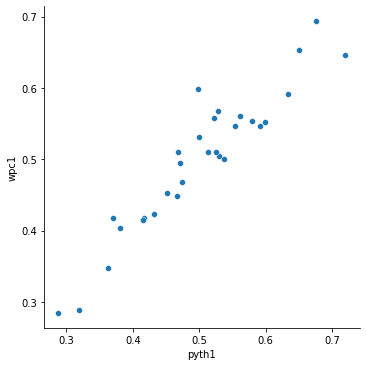

In [37]:
sns.relplot(x='pyth1', y='wpc1', data=half2_predictor)

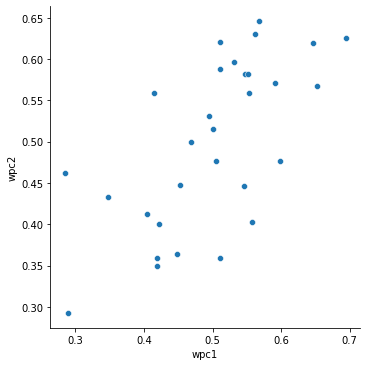

In [38]:
sns.relplot(x='wpc1', y='wpc2', data=half2_predictor)

# Correlation between key variables

In [39]:
keyvars = half2_predictor[['team', 'wpc2', 'wpc1', 'pyth1', 'pyth2']]

In [40]:
keyvars.corr()

,wpc2,wpc1,pyth1,pyth2
wpc2,1.000,0.653,0.691,0.924
wpc1,0.653,1.000,0.941,0.578
pyth1,0.691,0.941,1.000,0.660
pyth2,0.924,0.578,0.660,1.000


## Interpretation

* variable of interest on row index
* what's the correlation between the wpc2 and the wpc1, and between wpc2 and pyth1?
* correlation between wpc2 and pyth1 is HIGHER than that between wpc2 and wpc1.


This is why Bill James proposed pythagorean expectation is a better predictor than win percentage for future performance

In [42]:
keyvars.sort_values(by=['wpc2'], ascending=False)

,team,wpc2,wpc1,pyth1,pyth2
19,OAK,0.646,0.567,0.527,0.681
15,MIL,0.631,0.561,0.561,0.575
4,BOS,0.625,0.694,0.676,0.604
26,TBA,0.621,0.510,0.526,0.586
11,HOU,0.619,0.646,0.720,0.642
9,COL,0.597,0.531,0.499,0.561
25,SLN,0.588,0.511,0.513,0.589
8,CLE,0.582,0.547,0.591,0.650
13,LAN,0.582,0.552,0.599,0.683
6,CHN,0.571,0.591,0.634,0.504


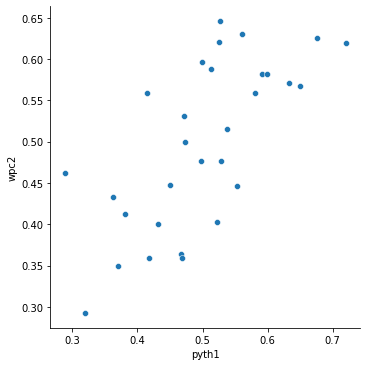

In [44]:
sns.relplot(y='wpc2', x='pyth1', data=keyvars)